In [50]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [51]:
BATCH_SIZE = 16
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [52]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Adidas Data Set",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1116 files belonging to 7 classes.


In [53]:
class_names = dataset.class_names
class_names


['Gazelle',
 'NMD_R1',
 'Pharrell',
 'Stan Smith',
 'Superstar',
 'Ultra4D',
 'Yeezy']

In [54]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 256, 256, 3)
[0 3 5 4 6 4 6 1 2 6 3 0 3 3 4 1]


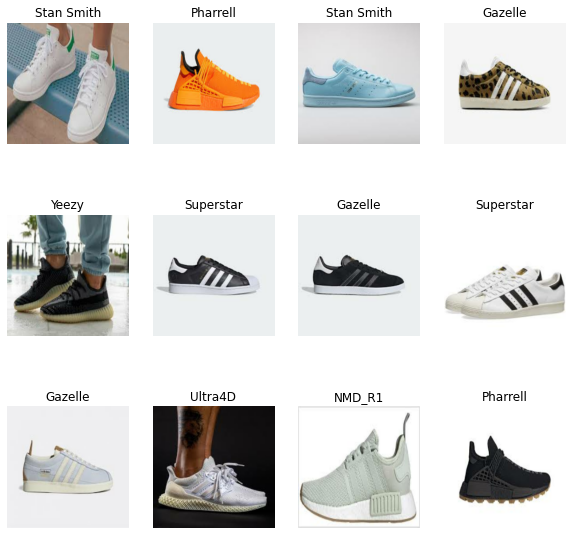

In [55]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [56]:
len(dataset)

70

In [57]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [58]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [59]:
len(train_ds)

56

In [60]:
len(val_ds)

7

In [61]:
len(test_ds)

7

In [62]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [63]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [64]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [65]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [66]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [67]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (16, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (16, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (16, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (16, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (16, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (16, 60, 60, 64)         

In [68]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [69]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
56/56 [==============================] - 35s 601ms/step - loss: 1.8915 - accuracy: 0.2533 - val_loss: 1.9227 - val_accuracy: 0.2232
Epoch 2/100
56/56 [==============================] - 33s 589ms/step - loss: 1.8603 - accuracy: 0.2612 - val_loss: 1.9475 - val_accuracy: 0.2143
Epoch 3/100
56/56 [==============================] - 34s 606ms/step - loss: 1.7975 - accuracy: 0.2824 - val_loss: 1.8304 - val_accuracy: 0.2411
Epoch 4/100
56/56 [==============================] - 35s 615ms/step - loss: 1.7273 - accuracy: 0.3025 - val_loss: 1.7814 - val_accuracy: 0.2679
Epoch 5/100
56/56 [==============================] - 38s 670ms/step - loss: 1.7447 - accuracy: 0.3181 - val_loss: 1.8447 - val_accuracy: 0.2589
Epoch 6/100
56/56 [==============================] - 38s 673ms/step - loss: 1.7195 - accuracy: 0.3158 - val_loss: 1.7495 - val_accuracy: 0.2589
Epoch 7/100
56/56 [==============================] - 38s 674ms/step - loss: 1.6920 - accuracy: 0.3203 - val_loss: 1.7449 - val_accuracy:

56/56 [==============================] - 44s 779ms/step - loss: 0.7727 - accuracy: 0.6964 - val_loss: 0.8135 - val_accuracy: 0.7143
Epoch 58/100
56/56 [==============================] - 45s 804ms/step - loss: 0.7297 - accuracy: 0.7165 - val_loss: 0.9913 - val_accuracy: 0.6607
Epoch 59/100
56/56 [==============================] - 49s 876ms/step - loss: 0.7461 - accuracy: 0.7422 - val_loss: 0.7961 - val_accuracy: 0.7321
Epoch 60/100
56/56 [==============================] - 46s 818ms/step - loss: 0.6834 - accuracy: 0.7522 - val_loss: 0.9129 - val_accuracy: 0.6875
Epoch 61/100
56/56 [==============================] - 47s 846ms/step - loss: 0.7592 - accuracy: 0.7254 - val_loss: 0.7984 - val_accuracy: 0.7411
Epoch 62/100
56/56 [==============================] - 50s 885ms/step - loss: 0.7147 - accuracy: 0.7433 - val_loss: 0.7787 - val_accuracy: 0.7411
Epoch 63/100
56/56 [==============================] - 45s 806ms/step - loss: 0.7139 - accuracy: 0.7266 - val_loss: 0.6871 - val_accuracy: 0.803

In [70]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 2s 166ms/step - loss: 0.3687 - accuracy: 0.8750


In [71]:
scores

[0.36873891949653625, 0.875]

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

ValueError: x and y must have same first dimension, but have shapes (50,) and (100,)

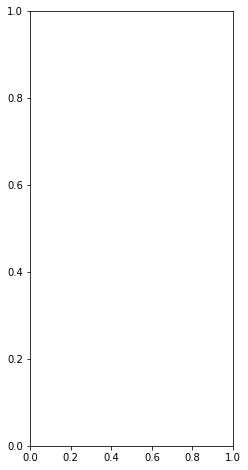

In [73]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: NMD_R1
predicted label: Ultra4D


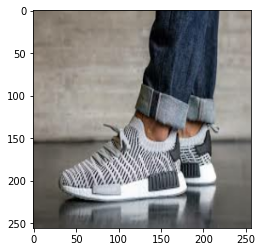

In [74]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [75]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

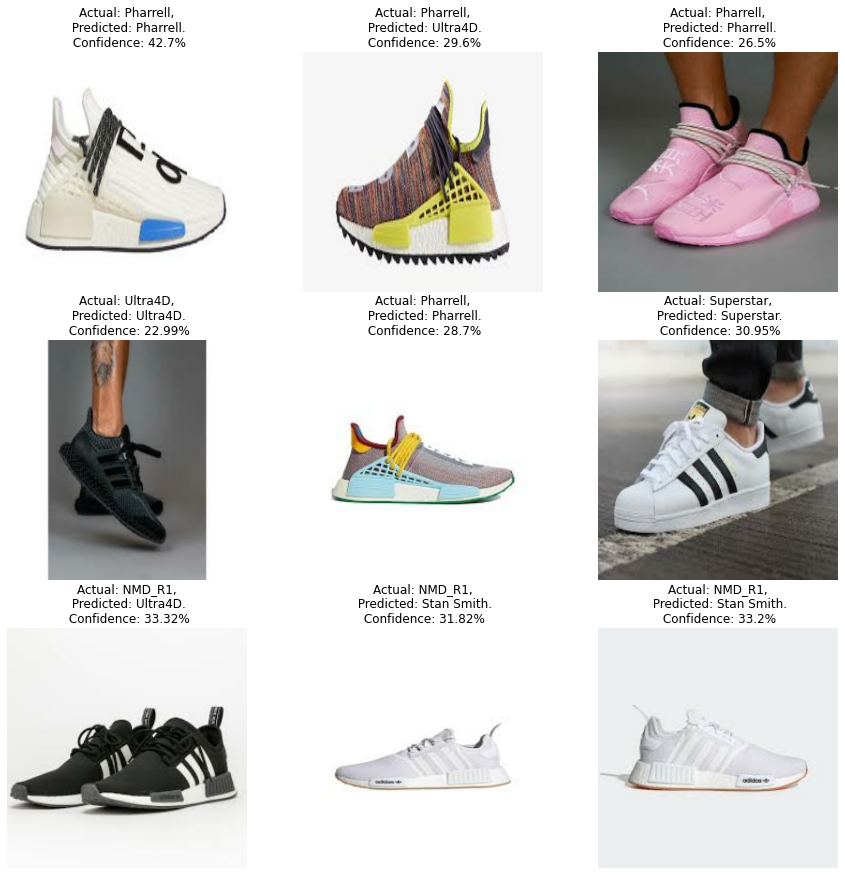

In [49]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")